# Matthew Peetz
# MSDE621: Final Project
# Regis University

## Calcuating Base Runs

# Assignment Objective

For this assignment a calculation from sabermetrics called **Base Runs** will be used to evaluate team batting performance. Base runs uses several of the "on base" statistics for players or entire teams to estimate an offensive potential. The base runs calculation is below.

BaseRunners x ScoreRate + HR
```
BaseRunners = A
ScoreRate = (B/(B+C))
HR = D
```
The the calculations can be represented by 
```
A*(B/(B + C)) + D

where,
A = H + BB - HR
B = (1.4*TB - .6*H - 3*HR + .1*BB)*1.02
C = AB - H
D = HR
```

<img style="padding-right:10px;" src="figures_wk7/standard_batting_detail.png" width=1200><br>

## Part 1. Pulling the Japanese Statistics

Part 1 will focus on (A) pulling the tables for the Japanese Teams. (B) compiling the tables into 1 data frame for all the Japanese Teams. (C) calculating the Base Runs for the Japanese Teams.

The first step of the project will focus on using the gazpacho library to scrap the required data for analysis.

In [1]:
# Loading all the libraries taht will be used in this notebook
from gazpacho import get, Soup
import numpy
import pandas
import requests, bs4
import re, os
import time

First step is going to be collecting all the urls off of the Japan Central League

### Part 1 (A) Pulling the Japanese Teams

To start a list of all the url's, one for each year, will be collected. This can then be iterated over to collect the correct tables from each page.

In [2]:
# The url for the Japanses Baseball Site
japan_url = f'https://www.baseball-reference.com/register/league.cgi?code=JPCL&class=Fgn'
html = get(japan_url)
soup = Soup(html)

After inspecting the site using Chrome the individual urls are stored under "th and data-stat / year_ID"

In [3]:
urls = Soup(get(japan_url)).find('th', {'data-stat':'year_ID'})

In [4]:
# Checking how long the list is
print(len(urls))

75


Now that I have a giant list of all the information I need to pull out just the parts of the url that are needed. After some trial and error I can split each list from 63:94 to get what I need, I will do that and add them to a new list.

In [5]:
# Collecting each unique part of the url into a list
tiny_urls = []
for i in urls:
    i = str(i)
    t = i[63:94]
    tiny_urls.append(t)
    #print(t) was used to test what is being stored

In [6]:
# Triming the first return out of the list, which is not an url, and checkign the list using the print command.
tiny_urls = tiny_urls[1:]
print(tiny_urls)

['register/league.cgi?id=e62e602d', 'register/league.cgi?id=6ffa4c10', 'register/league.cgi?id=0549ac26', 'register/league.cgi?id=4b244907', 'register/league.cgi?id=7f5a1dca', 'register/league.cgi?id=8449fb1b', 'register/league.cgi?id=5ed71981', 'register/league.cgi?id=fa996fac', 'register/league.cgi?id=ef7a4bc6', 'register/league.cgi?id=cbf62e9e', 'register/league.cgi?id=00cea8f5', 'register/league.cgi?id=d45883da', 'register/league.cgi?id=c512db3e', 'register/league.cgi?id=0e8aae4b', 'register/league.cgi?id=98417e4d', 'register/league.cgi?id=d2b06889', 'register/league.cgi?id=102ee2ae', 'register/league.cgi?id=bd17499f', 'register/league.cgi?id=4ce6298f', 'register/league.cgi?id=2a13bfad', 'register/league.cgi?id=5f92acab', 'register/league.cgi?id=b9ec01cb', 'register/league.cgi?id=f0f9b0a0', 'register/league.cgi?id=bbaa3356', 'register/league.cgi?id=3231e024', 'register/league.cgi?id=1b91c1f4', 'register/league.cgi?id=ed2dcf6e', 'register/league.cgi?id=6428c92c', 'register/league.cg

### Part 1 (B) Pulling the Japanese Teams Tables

The next step will be pulling the table out of each years specific url. This was the most challenging part of the assignment, as the tables are nested very deep. I used the code provided by Ben Kite to find what tables were on each page and how to correctly pull them.

In [7]:
# This was taken from the suggested github profile
# https://github.com/BenKite/baseball_data/blob/master/baseballReferenceScrape.py
def findTables(url):
    res = requests.get(url)
    ## The next two lines get around the issue with comments breaking the parsing.
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    divs = soup.findAll('div', id = "content")
    divs = divs[0].findAll("div", id=re.compile("^all"))
    ids = []
    for div in divs:
        searchme = str(div.findAll("table"))
        x = searchme[searchme.find("id=") + 3: searchme.find(">")]
        x = x.replace("\"", "")
        if len(x) > 0:
            ids.append(x)
    return(ids)
## For example:
## findTables("http://www.baseball-reference.com/teams/KCR/2016.shtml")

In [8]:
findTables('https://www.baseball-reference.com/register/league.cgi?id=e62e602d')

['regular_season', 'league_batting', 'league_pitching', 'league_fielding']

In [9]:
# This was also taken from the suggested github
# https://github.com/BenKite/baseball_data/blob/master/baseballReferenceScrape.py
def pullTable(url, tableID):
    res = requests.get(url)
    ## Work around comments
    comm = re.compile("<!--|-->")
    soup = bs4.BeautifulSoup(comm.sub("", res.text), 'lxml')
    tables = soup.findAll('table', id = tableID)
    data_rows = tables[0].findAll('tr')
    data_header = tables[0].findAll('thead')
    data_header = data_header[0].findAll("tr")
    data_header = data_header[0].findAll("th")
    game_data = [[td.getText() for td in data_rows[i].findAll(['th','td'])]
        for i in range(len(data_rows))
        ]
    data = pandas.DataFrame(game_data)
    header = []
    for i in range(len(data.columns)):
        header.append(data_header[i].getText())
    data.columns = header
    data = data.loc[data[header[0]] != header[0]]
    data = data.reset_index(drop = True)
    return(data)

In [10]:
# pulling the first table
table_2023 = pullTable('https://www.baseball-reference.com/register/league.cgi?id=e62e602d', 'league_batting')

In [11]:
# Adding in the year for the table
table_2023['Year'] = 2023
table_2023

,Tm,Aff,BatAge,R/G,G,PA,AB,R,H,2B,...,OBP,SLG,OPS,TB,GDP,HBP,SH,SF,IBB,Year
0,Hanshin Tigers,,27.2,3.88,105,4029,3512,407,863,137,...,.321,.346,.667,1214,62,39,75,36,23,2023
1,Yomiuri Giants,,28.5,3.87,103,3868,3510,399,896,149,...,.309,.413,.721,1448,65,31,58,20,27,2023
2,Yokohama Bay Stars,,29.3,3.64,104,3860,3463,379,859,161,...,.306,.367,.674,1272,81,40,72,24,15,2023
3,Yakult Swallows,,27.4,3.63,104,3875,3418,378,813,147,...,.308,.361,.669,1235,78,27,78,24,17,2023
4,Hiroshima Carp,,29.8,3.44,106,3867,3489,365,851,145,...,.301,.352,.654,1229,84,36,68,16,20,2023
5,Chunichi Dragons,,26.8,2.93,104,3821,3487,305,844,146,...,.291,.334,.625,1164,67,30,65,19,12,2023
6,League Totals,,28.2,3.57,626,23320,20879,2233,5126,885,...,.306,.362,.668,7562,437,203,416,139,114,2023


Now that everyting is working the code can be compiled into a loop to pull each table from the yearly stats page and build it into one larger table. A time pause was added, otherwise the pull request was rejected from the website.

In [12]:
# Code for pulling each table and building the data frame
import pandas as pd
year = 2022

japanese_frame = table_2023

for i in tiny_urls:
    url = 'https://www.baseball-reference.com/' + i
    print(url)
    table = pullTable(url, 'league_batting')
    table['Year'] = year
    japanese_frame = pd.concat([japanese_frame, table])
    year = year - 1
    print(year)
    time.sleep(5) # pull timing
    

https://www.baseball-reference.com/register/league.cgi?id=e62e602d
2021
https://www.baseball-reference.com/register/league.cgi?id=6ffa4c10
2020
https://www.baseball-reference.com/register/league.cgi?id=0549ac26
2019
https://www.baseball-reference.com/register/league.cgi?id=4b244907
2018
https://www.baseball-reference.com/register/league.cgi?id=7f5a1dca
2017
https://www.baseball-reference.com/register/league.cgi?id=8449fb1b
2016
https://www.baseball-reference.com/register/league.cgi?id=5ed71981
2015
https://www.baseball-reference.com/register/league.cgi?id=fa996fac
2014
https://www.baseball-reference.com/register/league.cgi?id=ef7a4bc6
2013
https://www.baseball-reference.com/register/league.cgi?id=cbf62e9e
2012
https://www.baseball-reference.com/register/league.cgi?id=00cea8f5
2011
https://www.baseball-reference.com/register/league.cgi?id=d45883da
2010
https://www.baseball-reference.com/register/league.cgi?id=c512db3e
2009
https://www.baseball-reference.com/register/league.cgi?id=0e8aae

In [13]:
# Checking the pulled data
japanese_frame

,Tm,Aff,BatAge,R/G,G,PA,AB,R,H,2B,...,SLG,OPS,TB,GDP,HBP,SH,SF,IBB,Year,Finals
0,Hanshin Tigers,,27.2,3.88,105,4029,3512,407,863,137,...,.346,.667,1214,62,39,75,36,23,2023,NaN
1,Yomiuri Giants,,28.5,3.87,103,3868,3510,399,896,149,...,.413,.721,1448,65,31,58,20,27,2023,NaN
2,Yokohama Bay Stars,,29.3,3.64,104,3860,3463,379,859,161,...,.367,.674,1272,81,40,72,24,15,2023,NaN
3,Yakult Swallows,,27.4,3.63,104,3875,3418,378,813,147,...,.361,.669,1235,78,27,78,24,17,2023,NaN
4,Hiroshima Carp,,29.8,3.44,106,3867,3489,365,851,145,...,.352,.654,1229,84,36,68,16,20,2023,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Yomiuri Giants,,27.1,5.17,140,5461,4831,724,1297,208,...,.401,.747,1937,117,,60,,0,1949,NaN
5,Nishinippon Pirates,,29.2,4.65,136,5197,4731,633,1233,175,...,.383,.706,1810,122,,27,,0,1949,NaN
6,Hiroshima Carp,,28.3,3.70,138,5173,4703,511,1145,162,...,.345,.651,1624,124,,52,,0,1949,NaN
7,Kokutetsu Swallows,,28.2,3.48,138,5070,4626,480,1131,142,...,.334,.638,1545,114,,51,,0,1949,NaN


In [14]:
# creating clean copy
j_df = japanese_frame

In [15]:
j_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 529 entries, 0 to 8
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tm      487 non-null    object
 1   Aff     529 non-null    object
 2   BatAge  529 non-null    object
 3   R/G     529 non-null    object
 4   G       529 non-null    object
 5   PA      529 non-null    object
 6   AB      529 non-null    object
 7   R       529 non-null    object
 8   H       529 non-null    object
 9   2B      529 non-null    object
 10  3B      529 non-null    object
 11  HR      529 non-null    object
 12  RBI     529 non-null    object
 13  SB      529 non-null    object
 14  CS      529 non-null    object
 15  BB      529 non-null    object
 16  SO      529 non-null    object
 17  BA      529 non-null    object
 18  OBP     529 non-null    object
 19  SLG     529 non-null    object
 20  OPS     529 non-null    object
 21  TB      529 non-null    object
 22  GDP     529 non-null    object
 2

The data is stored as objects, and will need to be numeric to use in calculations, so that will need to be fixed. It also needs the index reset

In [16]:
# Reset Index
j_df = j_df.reset_index()
j_df = j_df.apply(pd.to_numeric, errors='ignore')
j_df.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   529 non-null    int64  
 1   Tm      487 non-null    object 
 2   Aff     0 non-null      float64
 3   BatAge  529 non-null    float64
 4   R/G     529 non-null    float64
 5   G       529 non-null    int64  
 6   PA      529 non-null    int64  
 7   AB      529 non-null    int64  
 8   R       529 non-null    int64  
 9   H       529 non-null    int64  
 10  2B      529 non-null    int64  
 11  3B      529 non-null    int64  
 12  HR      529 non-null    int64  
 13  RBI     528 non-null    float64
 14  SB      529 non-null    int64  
 15  CS      529 non-null    int64  
 16  BB      529 non-null    int64  
 17  SO      529 non-null    int64  
 18  BA      529 non-null    float64
 19  OBP     529 non-null    float64
 20  SLG     529 non-null    float64
 21  OPS     529 non-null    float64
 22  TB

### Part 1 (C) Calculating Base Runs for the Japanese Teams

Calcuating Base Runs

After you have collected all the data for all the teams and all the years, it is time to create the base runs column. According to https://en.wikipedia.org/wiki/Base_runs, the formula to calculate base runs is:

BaseRunners x ScoreRate + HR

BaseRunners = A
ScoreRate = (B/(B+C))
HR = D

The the calculations can be represented by

A*(B/(B + C)) + D

where,
A = H + BB - HR
B = (1.4*TB - .6*H - 3*HR + .1*BB)*1.02
C = AB - H
D = HR


In [17]:
# Building out the calculation 
H = j_df.iloc[1]['H']
BB = j_df.iloc[1]['BB']
HR = j_df.iloc[1]['HR']
B2 = j_df.iloc[1]['2B']
B3 = j_df.iloc[1]['3B']
AB = j_df.iloc[1]['AB']
TB = j_df.iloc[1]['TB']

A = H + BB - HR
print("A is" , A)
B1 = (1.4*TB)
print("B1  ", B1)
B2 = (0.6*H) 
print("B2  ", B2)
B3 = (3*HR) 
print("B3  ", B3)
B4 = (.1*BB)
B = (B1-B2-B3+B4)
B = B*1.02

print("B is   ", B)
C = AB - H
print("C is    ", C)
D = HR
print("D is    ", D)

BaseRuns = A*(B/(B+C))+D

print(BaseRuns)

A is 1018
B1   2027.1999999999998
B2   537.6
B3   381
B is    1156.17
C is     2614
D is     127
439.18249044472793


In [18]:
# Calculating the base runs
i = 0
base_runs = []
while i < 529:
    H = j_df.iloc[i]['H']
    BB = j_df.iloc[i]['BB']
    HR = j_df.iloc[i]['HR']
    B2 = j_df.iloc[i]['2B']
    B3 = j_df.iloc[i]['3B']
    AB = j_df.iloc[i]['AB']
    TB = j_df.iloc[i]['TB']
    A = H + BB - HR
    B1 = (1.4*TB)
    B2 = (0.6*H) 
    B3 = (3*HR) 
    B4 = (.1*BB)
    B = (B1-B2-B3+B4)
    B = B*1.02
    C = AB - H
    D = HR
    x = A*(B/(B+C))+D
    base_runs.append(x)
    #print(i)
    #print(x)
    i = i+1

In [19]:
# There should be 529 values, checking to make sure that is true
print(len(base_runs))

529


In [20]:
# converting to a dataframe
base_run_df = pd.DataFrame(base_runs, columns=['BaseRuns'])

In [21]:
# Joining the dataframe with base runs to the japanese frame
j_new_df = j_df.join(base_run_df)
j_new_df.drop(['index'], axis=1, inplace=True)

In [22]:
# Checking to make sure that the frames were joined
j_new_df.head(5)

,Tm,Aff,BatAge,R/G,G,PA,AB,R,H,2B,...,OPS,TB,GDP,HBP,SH,SF,IBB,Year,Finals,BaseRuns
0,Hanshin Tigers,NaN,27.2,3.88,105,4029,3512,407,863,137,...,0.667,1214,62,39.0,75,36.0,23,2023,NaN,394.064047
1,Yomiuri Giants,NaN,28.5,3.87,103,3868,3510,399,896,149,...,0.721,1448,65,31.0,58,20.0,27,2023,NaN,439.182490
2,Yokohama Bay Stars,NaN,29.3,3.64,104,3860,3463,379,859,161,...,0.674,1272,81,40.0,72,24.0,15,2023,NaN,382.824062
3,Yakult Swallows,NaN,27.4,3.63,104,3875,3418,378,813,147,...,0.669,1235,78,27.0,78,24.0,17,2023,NaN,386.334308
4,Hiroshima Carp,NaN,29.8,3.44,106,3867,3489,365,851,145,...,0.654,1229,84,36.0,68,16.0,20,2023,NaN,364.969557


## Part 2. Pulling the American Statistics
The same process will be repeated as with the Japenese Statistics

### Taking a look at the American Team Links
#### Arizona Link
https://www.baseball-reference.com/teams/ARI/
#### Colorado Link
https://www.baseball-reference.com/teams/COL/

### Part 2 (A) Creating a List of the American URLs
First, the links for each team are going to need to be pulled. The base link for each team is https://www.baseball-reference.com/team + ARI, COL, SFG, LAD, and SDP. Using that infomation the sub links can all be pulled using a similar method to the one above.

In [23]:
# creating a list of all the team names
team_names = ['ARI', 'COL', 'SFG', 'LAD', 'SDP', 'ATL', 'BAL', 'BOS', 'CHC', 'WSN', 'TOR', 'TEX', 'TBD', 'STL', 'SEA', 'PIT',
             'PHI', 'OAK', 'NYY', 'NYM', 'MIN', 'MIL', 'FLA', 'ANA', 'KCR', 'HOU', 'DET', 'CLE', 'CIN', 'CHW']

In [24]:
# The url for the American Leagues
def get_urls(team):
    amer_tiny_urls = []
    base_url = f'https://www.baseball-reference.com/teams/'
    for i in team:
        print(i)                  # Print Command Used to Check i 
        team_url = base_url + i + '/batteam.shtml'
        print(team_url)            # Print Command Used to check final url  
        amer_tiny_urls.append(team_url)
    return(amer_tiny_urls)

In [25]:
# Creating a list of all the American Teams url's
amer_tiny_urls = get_urls(team_names)

ARI
https://www.baseball-reference.com/teams/ARI/batteam.shtml
COL
https://www.baseball-reference.com/teams/COL/batteam.shtml
SFG
https://www.baseball-reference.com/teams/SFG/batteam.shtml
LAD
https://www.baseball-reference.com/teams/LAD/batteam.shtml
SDP
https://www.baseball-reference.com/teams/SDP/batteam.shtml
ATL
https://www.baseball-reference.com/teams/ATL/batteam.shtml
BAL
https://www.baseball-reference.com/teams/BAL/batteam.shtml
BOS
https://www.baseball-reference.com/teams/BOS/batteam.shtml
CHC
https://www.baseball-reference.com/teams/CHC/batteam.shtml
WSN
https://www.baseball-reference.com/teams/WSN/batteam.shtml
TOR
https://www.baseball-reference.com/teams/TOR/batteam.shtml
TEX
https://www.baseball-reference.com/teams/TEX/batteam.shtml
TBD
https://www.baseball-reference.com/teams/TBD/batteam.shtml
STL
https://www.baseball-reference.com/teams/STL/batteam.shtml
SEA
https://www.baseball-reference.com/teams/SEA/batteam.shtml
PIT
https://www.baseball-reference.com/teams/PIT/battea

In [26]:
# Checkign the length of the list
print(len(amer_tiny_urls))

30


### Part 2 (B) Pulling all the Tables

In [27]:
def table_pull(url):
    html = get(url)
    soup = Soup(html)    
    # parse the outter level 'div'
    div = soup.find('div',{'id':'content'},mode='all')
    # Reconstruct the html string to represent what we want it to look like
    table = str(div[0].find('table', {'id':'yby_team_bat'})) + str(div[0].find('tbody')) + '</table>'
    # read into a pd dataframe
    df = pd.read_html(table)[0]
    return(df)

In [28]:
fullframe = table_pull(amer_tiny_urls[0])
fullframe['Team'] = 'ARI'

j = 0


while j<30:
    for i in amer_tiny_urls:
        z = (team_names[j])
        df = table_pull(amer_tiny_urls[j])
        df['Team'] = z
        df.head(5)
        fullframe = pd.concat([fullframe, df])
        j = j+1
        time.sleep(5)
        print(z)
        #z = table_pull(amer_tiny_urls[j])
        #z['Team'] = z


ARI
COL
SFG
LAD
SDP
ATL
BAL
BOS
CHC
WSN
TOR
TEX
TBD
STL
SEA
PIT
PHI
OAK
NYY
NYM
MIN
MIL
FLA
ANA
KCR
HOU
DET
CLE
CIN
CHW


In [29]:
# Checking that the full data set was pulled
fullframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830 entries, 0 to 122
Data columns (total 28 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   Year                                                                                      2830 non-null   int64  
 1   Lg                                                                                        2830 non-null   object 
 2   W                                                                                         2830 non-null   int64  
 3   L                                                                                         2830 non-null   int64  
 4   Finish                                                                                    2830 non-null   int64  
 5   R/G                                                          

In [30]:
# making a clean copy of the data frame
a_df = fullframe

In [31]:
# dropping the one odd column
a_df.drop(['Gold means awarded title at end of year." data-filter="1" data-name="Batting Average">BA'],axis=1, inplace = True)

In [32]:
a_df.head(5)

,Year,Lg,W,L,Finish,R/G,G,PA,AB,R,...,BB,SO,OBP,SLG,OPS,E,DP,Fld%,BatAge,Team
0,2023,NL West,60,60,3,4.68,120,4536,4052,561,...,390,926,0.323,0.420,0.742,40,99,0.991,27.3,ARI
1,2022,NL West,74,88,4,4.33,162,6027,5351,702,...,531,1341,0.304,0.385,0.689,86,134,0.985,26.5,ARI
2,2021,NL West,52,110,5,4.19,162,6144,5489,679,...,537,1465,0.309,0.382,0.692,100,113,0.983,28.9,ARI
3,2020,NL West,25,35,5,4.48,60,2238,1997,269,...,181,461,0.312,0.391,0.704,35,54,0.983,29.1,ARI
4,2019,NL West,85,77,2,5.02,162,6315,5633,813,...,540,1360,0.323,0.434,0.757,86,136,0.986,28.7,ARI


### Part 2 (C) Calculating the American Stats
The TB column does not exist, so the calculation will need to be changed to account for this

In [33]:
# Building out the calculation 
H = a_df.iloc[1]['H']
BB = a_df.iloc[1]['BB']
HR = a_df.iloc[1]['HR']
B2 = a_df.iloc[1]['2B']
B3 = a_df.iloc[1]['3B']
AB = a_df.iloc[1]['AB']
TB1 = (H + (B2*2) + (B3*3) + (HR*4))
#print(TB1)
TB2 = (B2+B3+HR)
#print(TB2)
TB = TB1 - TB2
#print("TB IS    ", TB)
print("HR is   ", HR)
print("BB is   ", BB)

A = H + BB - HR
print("A is" , A)
B1 = (1.4*TB)
print("B1  ", B1)
B2 = (0.6*H) 
print("B2  ", B2)
B3 = (3*HR) 
print("B3  ", B3)
B4 = (.1*BB)
B = (B1-B2-B3+B4)
B = B*1.02

print("B is   ", B)
C = AB - H
print("C is    ", C)
D = HR
print("D is    ", D)

BaseRuns = A*(B/(B+C))+D

print(BaseRuns)

HR is    173
BB is    531
A is 1590
B1   2885.3999999999996
B2   739.1999999999999
B3   519
B is    1713.9059999999997
C is     4119
D is     173
640.1960323036235


In [34]:
# Calculating the base runs
i = 0
base_runs = []
while i < 2202:
    H = a_df.iloc[i]['H']
    BB = a_df.iloc[i]['BB']
    HR = a_df.iloc[i]['HR']
    B2 = a_df.iloc[i]['2B']
    B3 = a_df.iloc[i]['3B']
    AB = a_df.iloc[i]['AB']
    TB1 = (H + (B2*2) + (B3*3) + (HR*4))
    TB2 = (B2+B3+HR)
    TB = TB1 - TB2
    A = H + BB - HR
    B1 = (1.4*TB)
    B2 = (0.6*H) 
    B3 = (3*HR) 
    B4 = (.1*BB)
    B = (B1-B2-B3+B4)
    B = B*1.02
    C = AB - H
    D = HR
    x = A*(B/(B+C))+D
    base_runs.append(x)
    #print(i)
    #print(x)
    i = i+1

In [35]:
print(len(base_runs))

2202


In [36]:
# Reseting the Index
a_df = a_df.reset_index()

In [37]:
base_run_df = pd.DataFrame(base_runs, columns=['BaseRuns'])

In [38]:
a_new_df = a_df.join(base_run_df)
a_new_df.drop(['index'], axis=1, inplace=True)

In [39]:
a_new_df.head(5)

,Year,Lg,W,L,Finish,R/G,G,PA,AB,R,...,SO,OBP,SLG,OPS,E,DP,Fld%,BatAge,Team,BaseRuns
0,2023,NL West,60,60,3,4.68,120,4536,4052,561,...,926,0.323,0.420,0.742,40,99,0.991,27.3,ARI,545.809261
1,2022,NL West,74,88,4,4.33,162,6027,5351,702,...,1341,0.304,0.385,0.689,86,134,0.985,26.5,ARI,640.196032
2,2021,NL West,52,110,5,4.19,162,6144,5489,679,...,1465,0.309,0.382,0.692,100,113,0.983,28.9,ARI,655.167365
3,2020,NL West,25,35,5,4.48,60,2238,1997,269,...,461,0.312,0.391,0.704,35,54,0.983,29.1,ARI,241.831356
4,2019,NL West,85,77,2,5.02,162,6315,5633,813,...,1360,0.323,0.434,0.757,86,136,0.986,28.7,ARI,781.176269


# Part 3 Combining the Data Frames

In [40]:
# Checking the Japanese Frame
j_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tm        487 non-null    object 
 1   Aff       0 non-null      float64
 2   BatAge    529 non-null    float64
 3   R/G       529 non-null    float64
 4   G         529 non-null    int64  
 5   PA        529 non-null    int64  
 6   AB        529 non-null    int64  
 7   R         529 non-null    int64  
 8   H         529 non-null    int64  
 9   2B        529 non-null    int64  
 10  3B        529 non-null    int64  
 11  HR        529 non-null    int64  
 12  RBI       528 non-null    float64
 13  SB        529 non-null    int64  
 14  CS        529 non-null    int64  
 15  BB        529 non-null    int64  
 16  SO        529 non-null    int64  
 17  BA        529 non-null    float64
 18  OBP       529 non-null    float64
 19  SLG       529 non-null    float64
 20  OPS       529 non-null    float6

In [41]:
# Checking the American Frame
a_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      2830 non-null   int64  
 1   Lg        2830 non-null   object 
 2   W         2830 non-null   int64  
 3   L         2830 non-null   int64  
 4   Finish    2830 non-null   int64  
 5   R/G       2830 non-null   float64
 6   G         2830 non-null   int64  
 7   PA        2830 non-null   int64  
 8   AB        2830 non-null   int64  
 9   R         2830 non-null   int64  
 10  H         2830 non-null   int64  
 11  2B        2830 non-null   int64  
 12  3B        2830 non-null   int64  
 13  HR        2830 non-null   int64  
 14  RBI       2828 non-null   float64
 15  SB        2790 non-null   float64
 16  CS        2408 non-null   float64
 17  BB        2830 non-null   int64  
 18  SO        2830 non-null   int64  
 19  OBP       2830 non-null   float64
 20  SLG       2830 non-null   floa

The Japanese frame has 30 columns, the American only 27. The American Frame includes Lg (league) which could be removed as it does not apply to the Japanese frame, as well as 'E', 'DP', and "Fld%). The Japanese Frame also includes Finals and and Aff, which can be dropped, as wells at 'TB', 'GDP', 'HBP', 'SH', 'SF', and 'IBB'. That will be the next step.

In [42]:
a_new_df.drop(['Lg', 'E', 'DP', 'Fld%', 'Finish', 'W', 'L'], axis=1, inplace = True)
a_new_df.head(5)

,Year,R/G,G,PA,AB,R,H,2B,3B,HR,...,SB,CS,BB,SO,OBP,SLG,OPS,BatAge,Team,BaseRuns
0,2023,4.68,120,4536,4052,561,1028,217,28,133,...,123.0,18.0,390,926,0.323,0.420,0.742,27.3,ARI,545.809261
1,2022,4.33,162,6027,5351,702,1232,262,24,173,...,104.0,29.0,531,1341,0.304,0.385,0.689,26.5,ARI,640.196032
2,2021,4.19,162,6144,5489,679,1297,308,31,144,...,43.0,16.0,537,1465,0.309,0.382,0.692,28.9,ARI,655.167365
3,2020,4.48,60,2238,1997,269,482,101,12,58,...,23.0,7.0,181,461,0.312,0.391,0.704,29.1,ARI,241.831356
4,2019,5.02,162,6315,5633,813,1419,288,40,220,...,88.0,14.0,540,1360,0.323,0.434,0.757,28.7,ARI,781.176269


In [43]:
a_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      2830 non-null   int64  
 1   R/G       2830 non-null   float64
 2   G         2830 non-null   int64  
 3   PA        2830 non-null   int64  
 4   AB        2830 non-null   int64  
 5   R         2830 non-null   int64  
 6   H         2830 non-null   int64  
 7   2B        2830 non-null   int64  
 8   3B        2830 non-null   int64  
 9   HR        2830 non-null   int64  
 10  RBI       2828 non-null   float64
 11  SB        2790 non-null   float64
 12  CS        2408 non-null   float64
 13  BB        2830 non-null   int64  
 14  SO        2830 non-null   int64  
 15  OBP       2830 non-null   float64
 16  SLG       2830 non-null   float64
 17  OPS       2830 non-null   float64
 18  BatAge    2830 non-null   float64
 19  Team      2830 non-null   object 
 20  BaseRuns  2202 non-null   floa

In [44]:
j_new_df.drop(['Finals', 'Aff', 'TB', 'GDP', 'HBP', 'SH', 'SF', "IBB", 'BA'],axis=1, inplace = True)
j_new_df.head(5)

,Tm,BatAge,R/G,G,PA,AB,R,H,2B,3B,...,RBI,SB,CS,BB,SO,OBP,SLG,OPS,Year,BaseRuns
0,Hanshin Tigers,27.2,3.88,105,4029,3512,407,863,137,26,...,391.0,55,21,367,881,0.321,0.346,0.667,2023,394.064047
1,Yomiuri Giants,28.5,3.87,103,3868,3510,399,896,149,11,...,390.0,37,19,249,800,0.309,0.413,0.721,2023,439.182490
2,Yokohama Bay Stars,29.3,3.64,104,3860,3463,379,859,161,15,...,367.0,21,22,261,610,0.306,0.367,0.674,2023,382.824062
3,Yakult Swallows,27.4,3.63,104,3875,3418,378,813,147,7,...,362.0,54,15,328,808,0.308,0.361,0.669,2023,386.334308
4,Hiroshima Carp,29.8,3.44,106,3867,3489,365,851,145,13,...,355.0,62,36,258,763,0.301,0.352,0.654,2023,364.969557


In [45]:
# Replacing tm with Team
j_new_df.rename(columns = {'Tm' : 'Team'}, inplace=True)
j_new_df.head(5)

,Team,BatAge,R/G,G,PA,AB,R,H,2B,3B,...,RBI,SB,CS,BB,SO,OBP,SLG,OPS,Year,BaseRuns
0,Hanshin Tigers,27.2,3.88,105,4029,3512,407,863,137,26,...,391.0,55,21,367,881,0.321,0.346,0.667,2023,394.064047
1,Yomiuri Giants,28.5,3.87,103,3868,3510,399,896,149,11,...,390.0,37,19,249,800,0.309,0.413,0.721,2023,439.182490
2,Yokohama Bay Stars,29.3,3.64,104,3860,3463,379,859,161,15,...,367.0,21,22,261,610,0.306,0.367,0.674,2023,382.824062
3,Yakult Swallows,27.4,3.63,104,3875,3418,378,813,147,7,...,362.0,54,15,328,808,0.308,0.361,0.669,2023,386.334308
4,Hiroshima Carp,29.8,3.44,106,3867,3489,365,851,145,13,...,355.0,62,36,258,763,0.301,0.352,0.654,2023,364.969557


In [46]:
j_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Team      487 non-null    object 
 1   BatAge    529 non-null    float64
 2   R/G       529 non-null    float64
 3   G         529 non-null    int64  
 4   PA        529 non-null    int64  
 5   AB        529 non-null    int64  
 6   R         529 non-null    int64  
 7   H         529 non-null    int64  
 8   2B        529 non-null    int64  
 9   3B        529 non-null    int64  
 10  HR        529 non-null    int64  
 11  RBI       528 non-null    float64
 12  SB        529 non-null    int64  
 13  CS        529 non-null    int64  
 14  BB        529 non-null    int64  
 15  SO        529 non-null    int64  
 16  OBP       529 non-null    float64
 17  SLG       529 non-null    float64
 18  OPS       529 non-null    float64
 19  Year      529 non-null    int64  
 20  BaseRuns  529 non-null    float6

In [47]:
# Adding a country tag to the data tables
a_new_df['Country'] = 'US'
j_new_df['Country'] = 'Japan'

In [61]:
# Combining the two frames
frames = [a_new_df, j_new_df]
complete_df =pd.concat(frames)

complete_df.head(5)

,Year,R/G,G,PA,AB,R,H,2B,3B,HR,...,CS,BB,SO,OBP,SLG,OPS,BatAge,Team,BaseRuns,Country
0,2023,4.68,120,4536,4052,561,1028,217,28,133,...,18.0,390,926,0.323,0.420,0.742,27.3,ARI,545.809261,US
1,2022,4.33,162,6027,5351,702,1232,262,24,173,...,29.0,531,1341,0.304,0.385,0.689,26.5,ARI,640.196032,US
2,2021,4.19,162,6144,5489,679,1297,308,31,144,...,16.0,537,1465,0.309,0.382,0.692,28.9,ARI,655.167365,US
3,2020,4.48,60,2238,1997,269,482,101,12,58,...,7.0,181,461,0.312,0.391,0.704,29.1,ARI,241.831356,US
4,2019,5.02,162,6315,5633,813,1419,288,40,220,...,14.0,540,1360,0.323,0.434,0.757,28.7,ARI,781.176269,US


# Part 4 Visualization

First, the list will be aggregated and sorted to determine which team has the highest Base Runs value and which team has the lowest base runs average.

In [72]:
df_avg = complete_df.groupby(['Team'])['BaseRuns'].agg(['mean'])
df_avg = df_avg.reset_index()
df_avg = df_avg.sort_values('mean')
df_avg

,Team,mean
36,Sankei Swallows,389.663634
18,Kokutetsu Swallows,404.548803
42,Taiyo-Shochiku Robins,405.719119
44,Yakult Atoms,426.189752
41,Taiyo Whales,464.710150
35,Sankei Atoms,471.267354
28,Osaka Tigers,484.723793
25,Nagoya Dragons,511.242116
15,Hiroshima Carp,515.998322
14,Hanshin Tigers,527.363503


It would appear that Colorado has the best Base Runs value and Sankei Swallows has the lowest.

Next, using the seaborn library, graphs will be constructed to view the data.

In [73]:
import seaborn as sns

<Axes: xlabel='mean', ylabel='Team'>

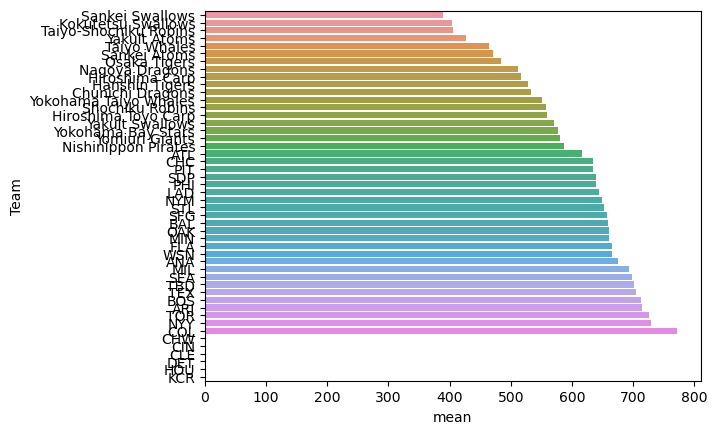

In [74]:
df_avg = df_avg.drop([20]) # Dropping League Totals
sns.barplot(data=df_avg, y="Team", x="mean")

Taking a look to see how the metrics have changed over the years

<Axes: xlabel='Year', ylabel='mean'>

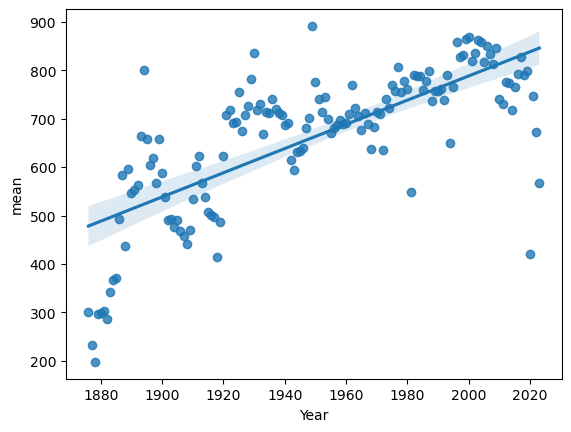

In [55]:
df_avg_year = complete_df.groupby(['Year'])['BaseRuns'].agg(['mean'])
df_avg_year = df_avg_year.reset_index()
sns.regplot(data=df_avg_year, x="Year", y="mean")

Taking a look at just the Colorado Rockies over the years

<Axes: xlabel='Year', ylabel='BaseRuns'>

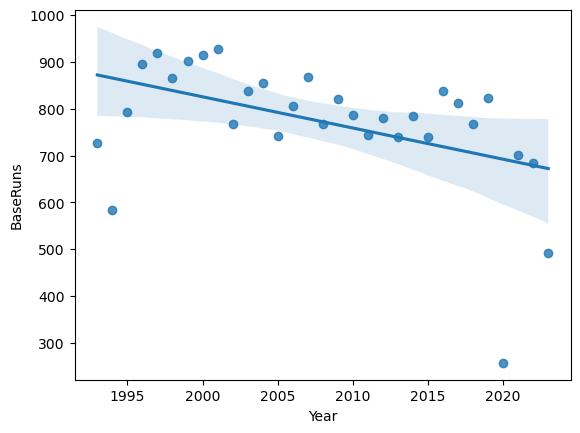

In [80]:
df_col = complete_df[complete_df['Team'] == 'COL']
sns.regplot(data=df_col, x="Year", y = "BaseRuns")

According to the regression plot, the Colorado Rockies have declined in performance over the year.

In [56]:
country_frame = complete_df.drop(columns = ['Team'])
#country_frame
country_runs = country_frame.groupby(['Country']).agg(['mean', 'count'])
country_runs


Year             R/G                 G                 PA   
                mean count      mean count        mean count         mean   
Country                                                                     
Japan    1985.725898   529  3.923894   529  229.047259   529  8579.931947  \
US       1966.909894  2830  4.499311  2830  154.185866  2830  5901.122615   

                        AB        ...       OBP             SLG         
        count         mean count  ...      mean count      mean count   
Country                           ...                                   
Japan     529  7649.538752   529  ...  0.315308   529  0.382571   529  \
US       2830  5257.596820  2830  ...  0.326855  2830  0.387695  2830   

              OPS           BatAge          BaseRuns        
             mean count       mean count        mean count  
Country                                                     
Japan    0.697853   529  28.318526   529  922.874097   529  
US       0.714546  2830  28.280565  2830  664.725135  2202  

[2 rows x 40 columns]

#### T-Test of Japans vs US Data to see if one has a better Base Runs value than another

In [75]:
from scipy.stats import ttest_ind

group1 = complete_df[complete_df['Country'] == "Japan"]
group2 = complete_df[complete_df['Country'] == "US"]
group2 = group2.dropna()



ttest_ind(group1['BaseRuns'], group2['BaseRuns'])

#print(group1['BaseRuns'])
#print(group2['BaseRuns'])


#data_japan.head()

Ttest_indResult(statistic=10.034009703146108, pvalue=3.092189321227097e-23)

Based on the P value there is a statistical difference.

A visualization of the Base Runs between the two contries.

<Axes: xlabel='Country', ylabel='BaseRuns'>

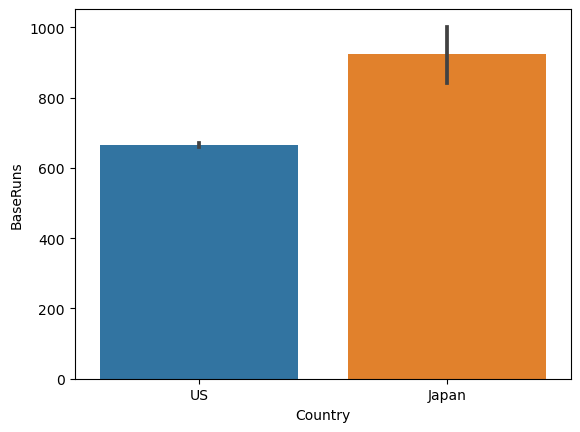

In [77]:
sns.barplot(data=complete_df, x='Country', y='BaseRuns')

# Summary

A scraper was used to collect baseball data off of a statistics website. That data was then used to calculate the metric "base runs", which can be used to compare base ball teams performance. Using those metrics it was determined that the Colorado Rockies have one of the best Base Run means in the country. The statisitic was also used to compare the Japanese League to the American teams. It was determined with statistical significance that the Japanese Teams outperform American Teams when looking at Base Run.